GoogLeNet是2014年Christian Szegedy提出的一种全新的深度学习结构，在这之前的**AlexNet、VGG等结构都是通过增大网络的深度来获得更好的训练效果**，但层数的增加会带来很多负作用，比如**overfit、梯度消失、梯度爆炸等**。\
卷积神经网络中对卷积升级的两个操作：**Inception 模型和 Residual （残差）模型**

**第二个版本的 Inception 模块采用了大量的 1x1 卷积,是为了降低输入特征图个数，目的就是起到通道压缩作用,不至于到最后特征图泛滥。**\
Inception 模块有两种形式，一种是原始模块，另一种是带有维度削减的模块。其结构如下图所示：
![在这里插入图片描述](https://img-blog.csdnimg.cn/20200608094315624.png)
构建好 Inception 模块后，将多个类似结构的Inception模块组合起来便是一个Inception 网络，类似下图：
![在这里插入图片描述](https://img-blog.csdnimg.cn/20200608094721464.png)

以上便是 Inception 网络的基本构造。这是当年获得冠军的 Inception V1 版本，可以看到模型层数很深了，**网络更深提取各种层级的特征更加充分**。
除此之外，Inception V1 在最**后两个全连接层中采取了一个全局平均池化层来代替全连接层**。因为**全连接层的参数数量庞大，通常是导致过拟合**的直接原因，这里用全局平均池化来代替，可以很大程度上缓解过拟合的情况。\
完整的 Inception V1 的结构信息如下表所示：
![在这里插入图片描述](https://img-blog.csdnimg.cn/20200608095106555.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L0lfYW1fYV9idWdlcg==,size_16,color_FFFFFF,t_70)


In [60]:
from keras.layers import Concatenate,Conv2D,MaxPool2D,Input,AvgPool2D,Dropout,Softmax,\
Dense,AvgPool2D,Flatten,ZeroPadding2D
from keras.models import Model
from keras.initializers import glorot_uniform
import tensorflow as tf 
import numpy as np

In [31]:
def inception_block(X,filters,stage):
    X_short,X_1,X_2,X_3=[X]*4 
    conv_name=f"conv_{stage}"
    conv_name_1=f"{conv_name}_1"
    conv_name_2=f"{conv_name}_2"
    max_pool_name=f"maxPool{stage}"
    f1,f2,f3,f4=filters
    X_short=Conv2D(filters=f1[0],kernel_size=(1,1),strides=1,padding='same',name=f"{conv_name}",kernel_initializer=glorot_uniform(0))(X_short)
    X_1=Conv2D(filters=f2[0],kernel_size=(1,1),strides=(1,1),padding='same',name=f"{conv_name_1}a",kernel_initializer=glorot_uniform(0))(X_1)
    X_1=Conv2D(filters=f2[1],kernel_size=(3,3),padding='same',name=f"{conv_name_2}a",kernel_initializer=glorot_uniform(0))(X_1)
    X_2=Conv2D(filters=f3[0],kernel_size=(1,1),strides=(1,1),padding='same',name=f"{conv_name_1}b",kernel_initializer=glorot_uniform(0))(X_2)
    X_2=Conv2D(filters=f3[1],kernel_size=(5,5),padding='same',name=f"{conv_name_2}b",kernel_initializer=glorot_uniform(0))(X_2)
    X_3=MaxPool2D(pool_size=(3,3),strides=1,padding='same',name=f"{max_pool_name}")(X_3)
    X_3=Conv2D(filters=f4[0],kernel_size=(1,1),padding='same',name=f"{conv_name_1}c",kernel_initializer=glorot_uniform(0))(X_3)
    X=Concatenate(axis=3)([X_3,X_2,X_1,X_short])
    return X 

In [56]:
def GoogleNet(input_shape,n_class):
    X_input=Input(input_shape)
#     0填充，就不用担心 图像尺寸过小了
    X=ZeroPadding2D((124,124))(X_input)
    X=Conv2D(filters=64,kernel_size=(7,7),strides=2,padding='same',activation='relu',kernel_initializer=glorot_uniform(0))(X)
    X=MaxPool2D(pool_size=3,strides=2)(X)
    X=Conv2D(filters=192,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer=glorot_uniform(0))(X)
    X=MaxPool2D(pool_size=3,strides=2)(X)
    X=inception_block(X,filters=[[64,],[96,128],[16,32],[32,]],stage="3a")
    X=inception_block(X,filters=[[128,],[128,192],[32,96],[64,]],stage="3b")
    X=MaxPool2D(3,2)(X)
    X=inception_block(X,[[192,],[96,128],[16,48],[64,]],stage="4a")
    X=inception_block(X,[[160,],[112,224],[24,64],[64,]],stage="4b")
    X=inception_block(X,[[128,],[128,256],[24,64],[64,]],stage="4c")
    X=inception_block(X,[[112,],[144,288],[32,64],[64,]],stage="4d")
    X=inception_block(X,[[256,],[160,320],[32,128],[128,]],stage="4e")
    X=MaxPool2D((3,3),2)(X)
    X=inception_block(X,[[256,],[160,320],[32,128],[128,]],stage="5a")
    X=inception_block(X,[[384,],[192,384],[48,128],[128,]],stage="5b")
    X=AvgPool2D((7,7),1)(X) 
    X=Dropout(.4)(X)
    X=Flatten()(X)
    X=Dense(n_class)(X)
    X=Softmax()(X) 
    model=Model(inputs=X_input,outputs=X,name='GNet')
    model.summary() 
    return model

In [55]:
from tensorflow.examples.tutorials.mnist import input_data 
import tensorflow as tf 
data=input_data.read_data_sets('./fashion-mnist/',one_hot=True)
X_train,y_train=data.train.images,data.train.labels
X_train=X_train.reshape((len(X_train),7,7,-1))  
X_test,y_test=data.test.images,data.test.labels
X_test=X_test.reshape((len(X_test),7,7,-1))
X_train.shape

Extracting ./fashion-mnist/train-images-idx3-ubyte.gz
Extracting ./fashion-mnist/train-labels-idx1-ubyte.gz
Extracting ./fashion-mnist/t10k-images-idx3-ubyte.gz
Extracting ./fashion-mnist/t10k-labels-idx1-ubyte.gz


(55000, 7, 7, 16)

In [57]:
from keras.utils import plot_model
model=GoogleNet(X_train.shape[1:],10)

Model: "GNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 7, 7, 16)     0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 255, 255, 16) 0           input_21[0][0]                   
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 128, 128, 64) 50240       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
max_pooling2d_65 (MaxPooling2D) (None, 63, 63, 64)   0           conv2d_36[0][0]                  
_______________________________________________________________________________________________

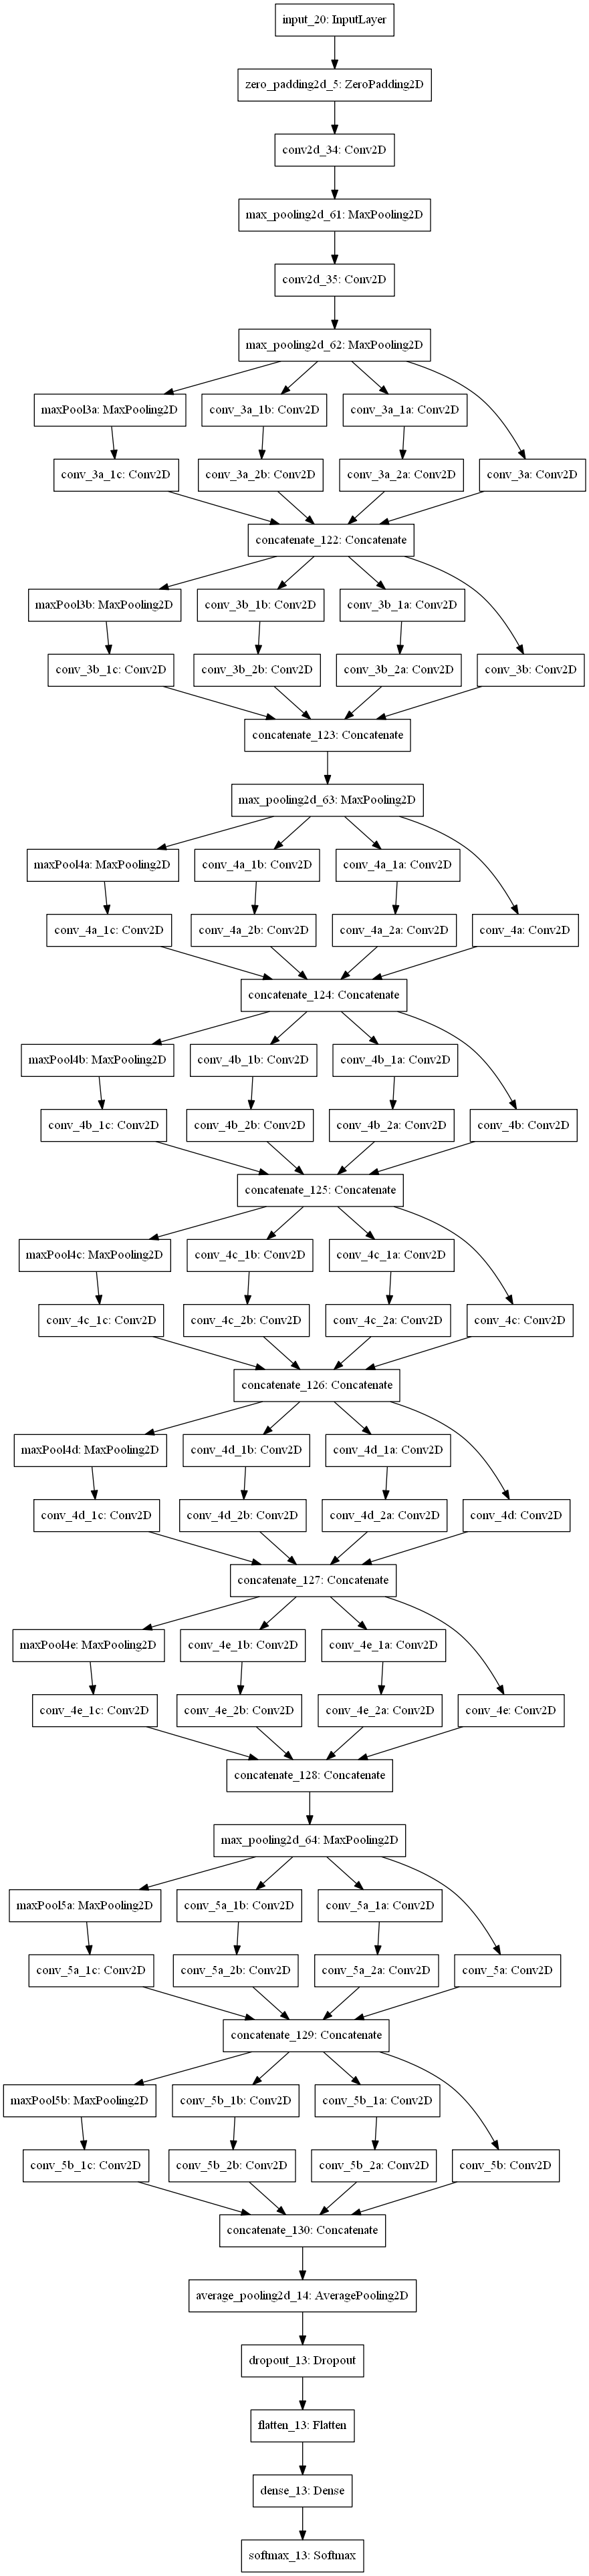

In [54]:
plot_model(model,'model.png')

In [58]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,epochs=4,steps_per_epoch=200)

Epoch 1/4


KeyboardInterrupt: 

实际上采用什么样的Inception Block最好，需要根据你的输出需要来定。比如要输出35*35尺寸的特征图，你不用费心调了，下面这个Inception Block最好：
![在这里插入图片描述](https://img-blog.csdnimg.cn/20200608094548914.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L0lfYW1fYV9idWdlcg==,size_16,color_FFFFFF,t_70)
如果要输出17*17尺寸的特征图？没关系，这个Inception Block最好：
![在这里插入图片描述](https://img-blog.csdnimg.cn/20200608094629219.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L0lfYW1fYV9idWdlcg==,size_16,color_FFFFFF,t_70)